In [98]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors



In [91]:
# Read in data

file_name = 'cah2_chembl_data_plus_rdkit_descriptors.csv'
df = pd.read_csv(os.path.join('data',file_name))
df.drop_duplicates(subset=['molecule_chembl_id'], keep=False, inplace=True)
df.set_index('molecule_chembl_id', inplace=True)



In [92]:
# Filter and visualise the data
i = 0
for col in df.columns:
    i += 1
    print(i, col, sep='\t')
    if df[col][0] == 777.0:
        df.drop(col)

df


1	Unnamed: 0
2	target_chembl_id
3	canonical_smiles
4	standard_type
5	assay_type
6	pchembl_value
7	RDKit_Molecule
8	BalabanJ
9	BertzCT
10	Ipc
11	HallKierAlpha
12	MolLogP
13	MolMR
14	MolWt
15	ExactMolWt
16	HeavyAtomCount
17	HeavyAtomMolWt
18	NHOHCount
19	NOCount
20	NumHAcceptors
21	NumHDonors
22	NumHeteroatoms
23	NumRotatableBonds
24	NumValenceElectrons
25	NumAmideBonds


KeyError: "['NumAmideBonds'] not found in axis"

molecule_chembl_id
CHEMBL100075    8.15
CHEMBL100266    8.68
CHEMBL100329    8.77
CHEMBL100456    8.15
CHEMBL100580    6.50
                ... 
CHEMBL99697     7.82
CHEMBL99736     8.15
CHEMBL99855     8.40
CHEMBL99927     8.55
CHEMBL99958     6.60
Name: pchembl_value, Length: 4966, dtype: float64

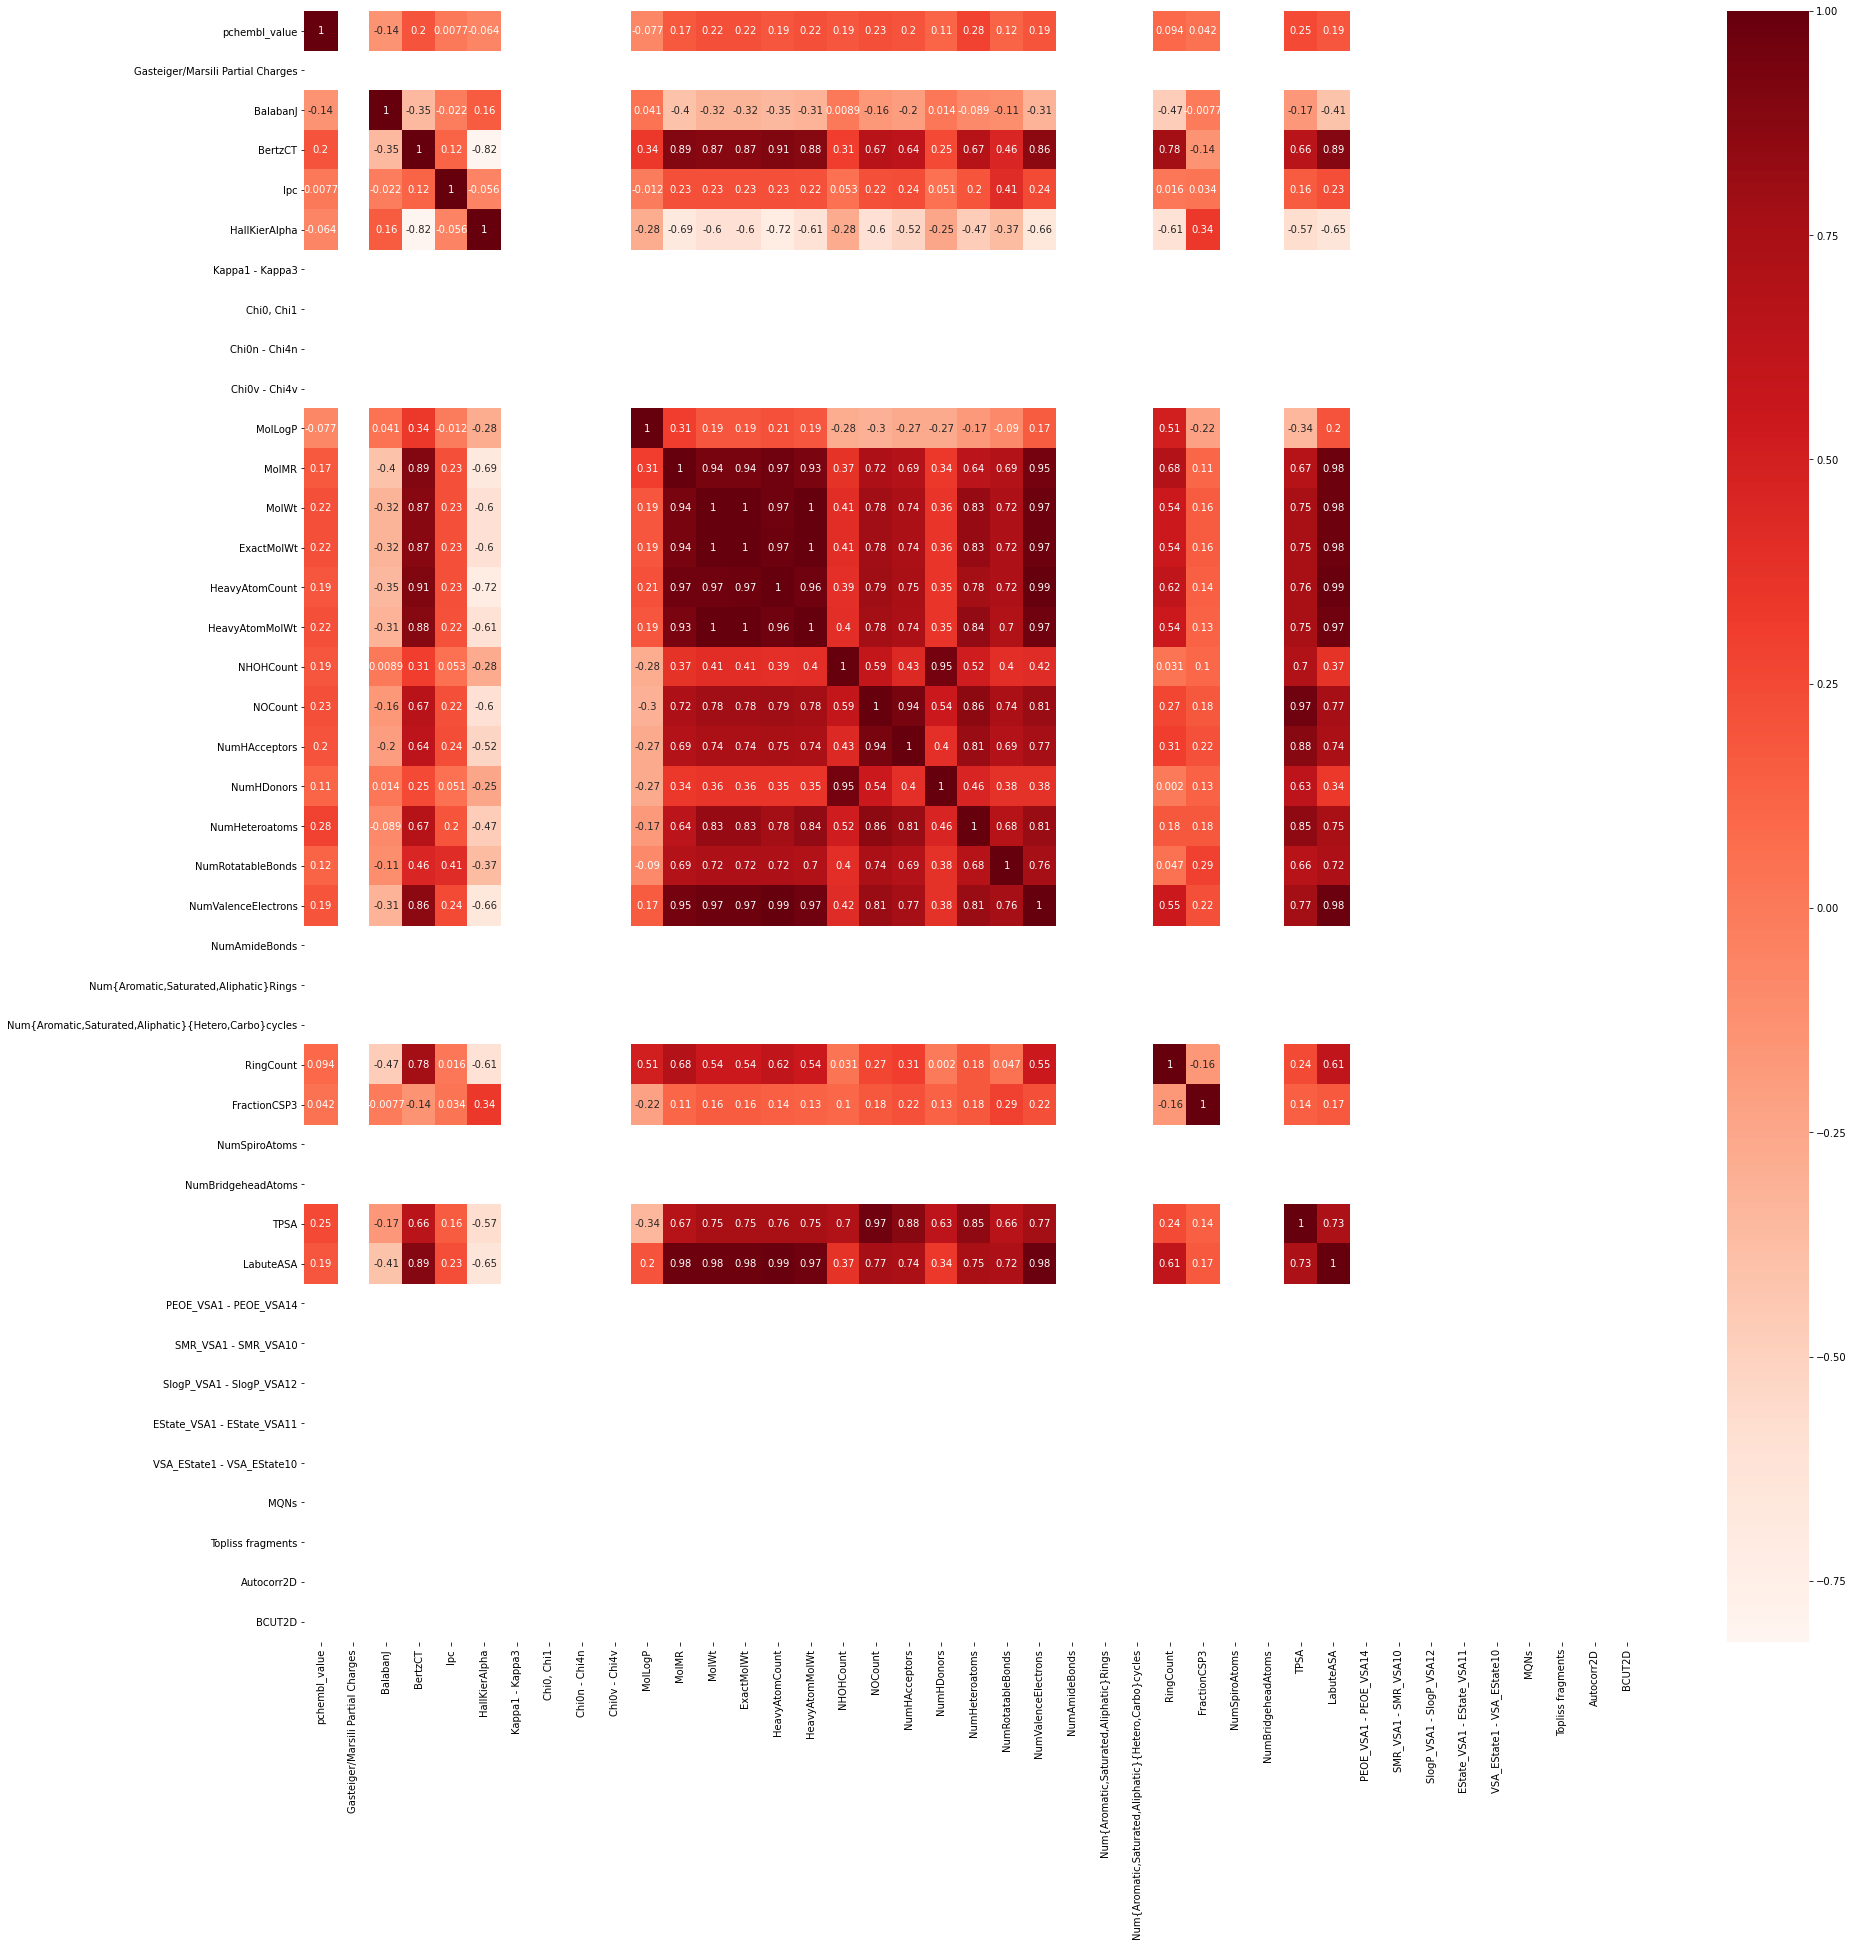

In [68]:
#Using Pearson Correlation
fig, axes = plt.subplots(1,1,figsize=(30,30))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)


#Correlation with output variable
cor_target = abs(df["pchembl_value"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features



In [7]:
ligand_efficiency = df['pchembl_value'] / descriptors.loc[df.index]['n_atoms']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(descriptors.loc[df.index]['n_atoms'], ligand_efficiency, alpha=0.5)
ax.set_xlabel('Number of heavy atoms')
ax.set_ylabel('pK/heavy atom')
plt.close()

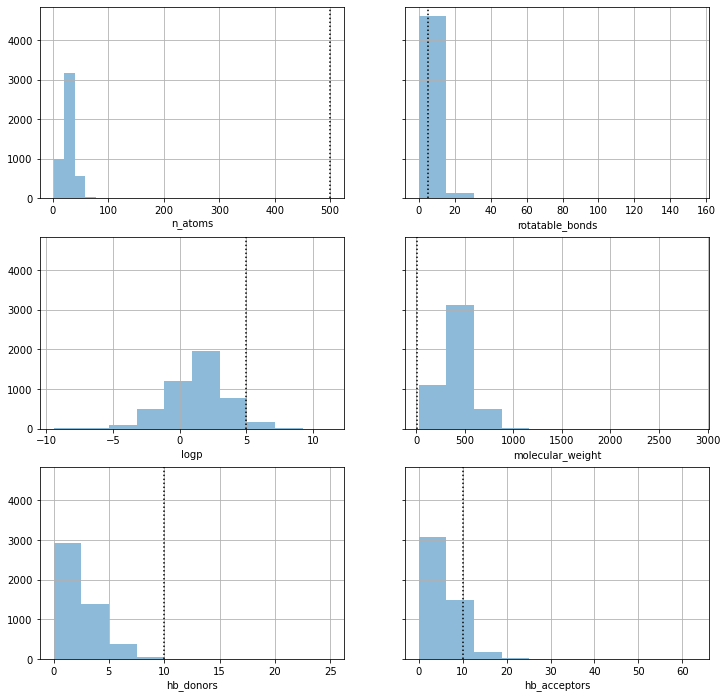

In [22]:
fig, axes = plt.subplots(3,2,figsize=(12,12), sharey=True)
axes = axes.flat

i = 0
cols = descriptors.columns
axvline = [500,5,5,10,10,10]
for col in cols:
    descriptors[col].hist(ax=axes[i],alpha = 0.5)
    axes[i].axvline(axvline[i], color='k', linestyle=':')
    axes[i].set_xlabel(col)
    i += 1



In [35]:
# Split the data (randomly) into train and test
X = descriptors.to_numpy()
y = df['pchembl_value'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# The following models require hyperparameter tuning and hence a val set
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=1/9, random_state=1) # (1/9) x 0.9 = 0.1

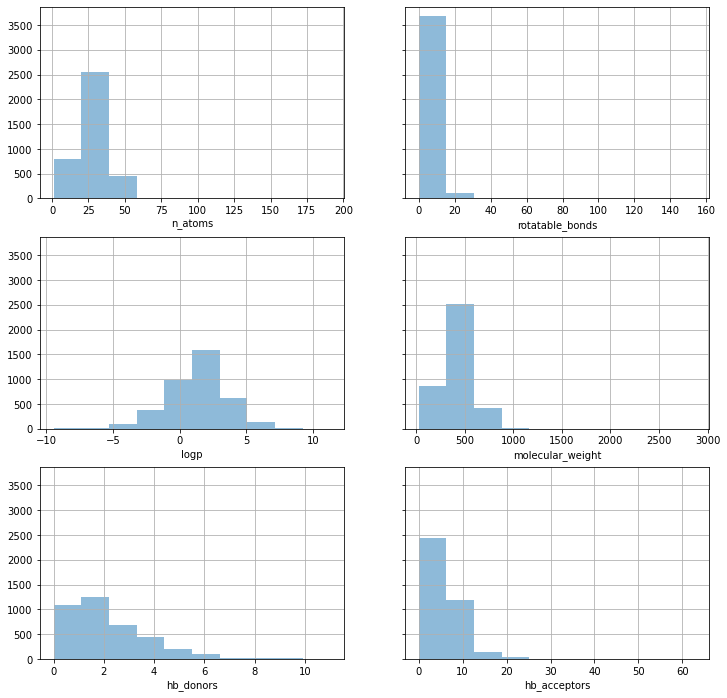

In [37]:
sc = preprocessing.StandardScaler()
X_train_sc = sc.fit_transform(X_train)
sc.transform(X_val)
cols = descriptors.columns

i = 0
sc_df = {}
for col in cols:
    sc_df[col] = X_train[:,i]
    i += 1
sc_df = pd.DataFrame(sc_df)
fig, axes = plt.subplots(3,2,figsize=(12,12), sharey=True)
axes = axes.flat

#axvline = [500,5,5,10,10,10]
i = 0
for col in cols:
    sc_df[col].hist(ax=axes[i],alpha = 0.5)
    #axes[i].axvline(axvline[i], color='k', linestyle=':')
    axes[i].set_xlabel(col)
    i += 1

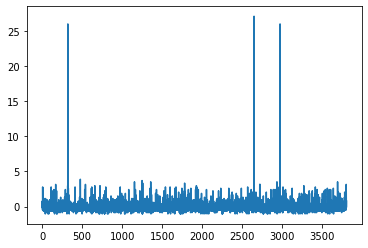

In [38]:
plt.plot(X_train_sc[:,1])

In [100]:
# Linear Regression - Baseline Model
lr = LinearRegression()
reg = lr.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Model Evaluation
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))




AttributeError: 'LinearRegression' object has no attribute 'fit_transform'

In [12]:
# This section is for hyperparmeter tuning. Different combinations of hyperparameters are tested to see the optimal combination

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [13]:

# Fitting using chosen method
model_rfr = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = model_rfr, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)

# fit the model with the training data
rf_random.fit(X_train, y_train)

rf_random.best_params_
#TODO The grid defined above is a coarse grid. Given the best_params_ output from the initial run, we now change our grid search to include values that arecloser to the ones that performed best on the coarse grid. Eventually, we arrive at a combination of hyperparameters that we can't improve on



Fitting 4 folds for each of 1 candidates, totalling 4 fits


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [14]:
# predict the target on train and test data 
predict_train = rf_random.predict(X_train)
predict_val = rf_random.predict(X_val)
predict_test  = rf_random.predict(X_test)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(y_train, predict_train)**(0.5))
print('RMSE on val data: ', mean_squared_error(y_val, predict_val)**(0.5))
print('RMSE on test data: ',  mean_squared_error(y_test, predict_test)**(0.5))

RMSE on train data:  0.643881223506472
RMSE on val data:  0.920217906180101
RMSE on test data:  0.9476035599306744


In [15]:
# Visualising rfr results
# Extract single tree
estimator = rf_random.best_estimator_

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = descriptors.columns,
                class_names = 'pChembl',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'